# Sistemas Autônomos - Trabalho 4 - Grid e Monte Carlo Localization



## Imports e funções auxiliares

Funções necessárias para implementação dos algoritmos e funções de plot para facilitar a visualização de seu funcionamento.

Para comparação de ângulos, foram implementadas duas funções. A primeira é uma projeção ("*normalização*") de ângulos de maneira a adequar os ângulos passados para o domínio [-π, π]. A segunda retorna a localização relativa, ou seja, o menor arco de um ângulo em relação a um um observador de referência.

A função prob foi alterada para incluir um desvio desprezível no  σ para dar estabilidade numérica de maneira pode ser utilizada de maneira aproximadamente determinística.

Para realização da reamostragem dos algoritmos foi implementado o algoritmo *Stochastic Universal Sampler* na forma de uma função.




In [4]:
from copy import deepcopy
import numpy as np
from numpy import sin, cos, sqrt, pi, arctan2, sign
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Circle, Wedge, ConnectionPatch
from math import fmod
import shapely.geometry as shp
import seaborn as sns
np.random.seed(7)


# fundamentals and problem geometry
def normalize_angle(angle):
    while angle > pi:
        angle -= 2 * pi
    while angle < -pi:
        angle += 2 * pi
    return angle


def smaller_arc_between_angles(observer_angle, target_angle):
    observer_angle = normalize_angle(observer_angle)
    target_angle = normalize_angle(target_angle)

    angle_difference = target_angle - observer_angle

    angle_difference = normalize_angle(angle_difference)

    return angle_difference


def stochastic_universal_sampler(w_array, n_samples):
    if w_array.sum() == 0:
        prob = np.ones_like(w_array) / len(w_array)
    else:
        prob = w_array / w_array.sum()

    cum_prob = np.cumsum(prob)
    r = np.random.uniform(0, 1/n_samples)
    id_sel_list = []
    i = 0
    if n_samples > 0:
        while len(id_sel_list) < n_samples:
            if i < len(cum_prob):
                while r < cum_prob[i]:
                    id_sel_list.append(i)
                    r += 1 / n_samples
            else:
                id_sel_list.append(len(w_array) - 1)
            i += 1
    return id_sel_list


def get_random_samples(n_samples, area_map):
  X0 = []
  min_x, max_x, min_y, max_y = area_map.get_map_limits()
  while len(X0) < n_samples:
      x = np.random.uniform(low=min_x, high=max_x)
      y = np.random.uniform(low=min_y, high=max_y)
      theta = np.random.uniform(-pi/2, pi/2)
      if not area_map.point_is_occupied((x, y)):
          X0.append([x, y, theta])

  Xt = np.array(X0).T
  w0 = np.ones_like(Xt[0])
  Xt = np.vstack((Xt, w0))
  return Xt



def prob(dist, sigma):
    if sigma < 1e-5:
        sigma += 1e-5
    p = np.exp(-.5 * dist ** 2 / sigma ** 2) / sqrt(2 * pi * sigma**2)
    return p




In [5]:

# funções de plots
def plot_robot_v3(pose, radius=0.3, color='black', zorder=2):
  center = (pose[0], pose[1])
  ang = pose[2] * 180 / np.pi

  circ = Circle(center, radius, fill=False, color=color, zorder=zorder)
  wed = Wedge(center, radius, ang-2, ang+2, color=color, zorder=zorder)

  return [circ, wed]

def plot_robots_in_map(xt, reference_map, extra_patches=None, grid_res=None, title=None):
    assert type(reference_map) == Map

    map_patches = reference_map.get_patches()
    robot_patches = []
    for i in range(len(xt.T)):
        robot_patches += plot_robot_v3(pose=xt.T[i], radius=0.3)

    all_patches = map_patches + robot_patches
    if extra_patches is not None:
        all_patches += extra_patches

    fig, ax = plt.subplots()

    for p in all_patches:
        ax.add_artist(p)

    min_x, max_x, min_y, max_y = reference_map.get_map_limits()

    if grid_res is not None:
        n_x_grids = int((max_x - min_x) / grid_res) + 1
        n_y_grids = int((max_y - min_y) / grid_res) + 1
        x_grids = np.linspace(min_x, max_x, n_x_grids)
        y_grids = np.linspace(min_y, min_y, n_y_grids)
        ax.set_xticks(x_grids, minor=True)
        ax.set_yticks(y_grids, minor=True)
        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.5)
        ax.grid(which='major', alpha=0.5)

    if title:
        ax.set_title(title)

    ax.axis('square')
    ax.set_xlim((min_x, max_x))
    ax.set_ylim((min_y, max_y))
    plt.grid()
    plt. show()


def plot_MCL_scene(Xtp, Xt, xt_real, i, camera_range, camera_fov, area_map):
    xti_real = xt_real[:, i]
    # plot
    particles_original_pats0 = []
    for p in Xtp.T[:min(1000, Xtp.shape[1]), :]:
        particles_original_pats0 += plot_robot_v3(p, color='tan', zorder=1, radius=0.1)
    particles_original_pats = deepcopy(particles_original_pats0)
    camera_plot = [Wedge(center=xti_real[:2].T, r=camera_range,
                         theta1=((xti_real[2] - camera_fov / 2) * 180 / pi).item(),
                         theta2=((xti_real[2] + camera_fov / 2) * 180 / pi).item(),
                         color='lightgreen', zorder=0)]
    real_robot = plot_robot_v3(xti_real, color='red', zorder=3)
    plot_robots_in_map(xt_real[:, :i], area_map, real_robot + particles_original_pats0 + camera_plot,
                       title=f'move and read camera i={i}')

    # plot 2
    particles_resamp_pats = []
    for p in Xt.T[:min(1000, Xt.shape[1]), :]:
        particles_resamp_pats += plot_robot_v3(p, color='orange', zorder=2, radius=0.1)
    real_robot = plot_robot_v3(xti_real, color='red', zorder=3)
    plot_robots_in_map(xt_real[:, :i], area_map, real_robot + particles_resamp_pats + particles_original_pats,
                       title=f'localization and resampling, i={i}')


## Modelos e Amostradores de Base:

Para implmentação dos algoritmos é necessário o uso de modelos de movimento e de percepção do ambiente, bem como um amostrador baseado em um modelo de movimento. Foram escolhidos o modelo de movimento e amostrador baseados na dinâmiaca por velocidade  (*motion_model_velocity* e *sample_model_velocity*) e o modelo de percepção foi o (*landmark_model_known_correspondence*).

As funções deste bloco já foram previamente apresentadas em trabalhos anteriores.




In [6]:
def sample_model_velocity(u_t, x_tp, n_samples, alphas, deltat):
    """
        input:
            x_tp -> estado em tempo previo            componentes: [x, y, theta, n]
            u_t -> controle considerando velocidade   componentes: [v, w]
        output:
            x_t -> estado em tempo corrente.          componentes: [xl, yl, thetal, n * n_sample]
    """
    x = x_tp[0, :]
    y = x_tp[1, :]
    theta = x_tp[2, :]

    v = u_t[0]
    w = u_t[1]

    x = np.tile(x, (1, n_samples))
    y = np.tile(y, (1, n_samples))
    theta = np.tile(theta, (1, n_samples))

    vhat = np.random.normal(v, alphas[0] * v ** 2 + alphas[2] * w ** 2)
    what = np.random.normal(w, alphas[2] * v ** 2 + alphas[3] * w ** 2)
    gammahat = np.random.normal(np.zeros_like(theta), alphas[4] * v ** 2 + alphas[5] * w ** 2)

    if what == 0:
        what += 1e-6

    rhat = vhat / what
    thetahat = theta + what * deltat

    rhat = np.clip(rhat, -1e8, 1e8)

    xl = x - rhat * (sin(theta) - sin(thetahat))
    yl = y + rhat * (cos(theta) - cos(thetahat))
    thetal = thetahat + gammahat * deltat

    res = np.vstack((xl, yl, thetal))

    return res


def motion_model_velocity(x_t, u_t, x_tp, alphas, deltat):
    """
      input:
        x_t -> estado em tempo corrente.          componentes: [xl, yl, thetal]
        x_tp -> estado em tempo previo            componentes: [x, y, theta]
        u_t -> controle considerando velocidade   componentes: [v, w]
      output:
        p -> distribuiçao (p_1 * p_2 * p_3 )
    """
    xl = x_t[0, :]
    yl = x_t[1, :]
    thetal = x_t[2, :]

    x = x_tp[0, :]
    y = x_tp[1, :]
    theta = x_tp[2, :]

    v = u_t[0]
    w = u_t[1]

    if abs(((y - yl) * cos(theta) - (x - xl) * sin(theta))) < 1e-6:
        mu = 1e5
    else:
        mu = 0.5 * ((x - xl) * cos(theta) + (y - yl) * sin(theta)) / ((y - yl) * cos(theta) - (x - xl) * sin(theta))

    xstar = (x + xl) / 2 + mu * (y - yl)
    ystar = (y + yl) / 2 + mu * (xl - x)
    rstar = sqrt((x - xstar) ** 2 + (y - ystar) ** 2)

    deltatheta = np.arctan2(yl - ystar, xl - xstar) - np.arctan2(y - ystar, x - xstar)

    what = deltatheta / deltat
    vhat = what * rstar
    gammahat = (thetal - theta) / deltat - what

    p1 = prob(v - vhat, alphas[0] * v ** 2 + alphas[1] * w ** 2)
    p2 = prob(w - what, alphas[2] * v ** 2 + alphas[3] * w ** 2)
    p3 = prob(gammahat, alphas[4] * v ** 2 + alphas[5] * w ** 2)

    return p1 * p2 * p3


def landmark_model_known_correspondence(fit, cit, xt, m, sigmas):
    """
    inputs:
        cit: int -> indice do landmark no mapa.
        xt: 3 x S -: São tratadas S amostras. Cada uma correspondente a uma coluna [x, y, theta]^T.
        fit: 3 x 1 -> A leitura do landmark corresponde a colunas [r, phi, s].T.
        sigmas: 3 x 1 -> são obtidas os desvios padrão para cada uma das medições relativas dos landmarks.
        m: Map -> mapa do cenário conforme classe implementada.

    output:
        q: 1 x S -> vetor com as likelihoods de cada uma das amostras considerando a leitura realizada.
    """
    assert type(m) == Map
    mjx, mjy = m.landmarks[cit]       # lookup da posição do landmark no map

    x = xt[0, :]                        # estado hipotético do robô
    y = xt[1, :]
    theta = xt[2, :]

    rit = fit[0]
    phiit = fit[1]
    # sit = fit[2]                # não utlizado -> considerando a leitura perfeita dos atributos.

    sigma_r = sigmas[0]         # obtenção variância de r e phi
    sigma_phi = sigmas[1]
    # sigma_s = sigmas[2]         # não utlizado -> considerando a leitura perfeita dos atributos.

    rhat = sqrt((mjx - x)**2 + (mjy - y)**2)
    phihat = np.zeros_like(theta)
    for i, theta_i in enumerate(theta):
      phihat[i] = smaller_arc_between_angles(observer_angle=theta_i, target_angle=arctan2(mjy - y[i], mjx - x[i]))

    # phihat = arctan2(mjy - y, mjx - x) - theta

    q = prob(abs(rit - rhat), sigma_r) * prob(abs(phiit - phihat), sigma_phi)

    return q


## Classes Auxiliares

Map: classe que abstrai um mapa no paradigma *feature-based*. O mapa consiste, em termos de implementação, em uma lista de obstáculos, que por sua vez devem ser passados como uma lista de vértices consecutivos de um polígono, um dicionário de landmarkd, cujas chaves são os identificadores dos landmarks e os valores são tuplas com as posições. Por último, o mapa também recebe os limites da área da mesma forma que os obstáculos. Os mapas posuem ainda funções para verificação da ocupação de pontos, obtenção de patches para plot, e uma implementação da varredura dos landmarks por uma câmera modelada em termos de FoV e range.

H_grid: Consiste em uma classe para armazenar uma interpretação do mapa como um grid de células que armazenam o número de ocorrência em cada célula.

P_grid: Extensão da classe anterior que normaliza as ocorrências de maneira a obter um grid de probabilidades.



In [7]:
class Map:
    def __init__(self, obstacles, landmarks, area_limit):
        """
        obstacles: deve ser uma lista de obstaculos.
                    o obstáculo é um polígono e deve ser convexos, definidos por pontos sequenciais.
        landmarks: é construído como um dicionário, com a key inteira e sequencial definindo como um identificador
                    o value da entrada do dicionário deve ser uma tupla (x_i, y_i)
        area_limit: deve ser um poligono convexo, conforme os obstacles
        """

        self.obstacles = obstacles
        self.landmarks = landmarks
        self.area_limit = area_limit

    def get_patches(self):
      patches = []
      background = Polygon(np.array(self.area_limit), color='white', zorder=-1)
      patches.append(background)

      for obs in self.obstacles:
        pat = Polygon(np.array(obs), closed=True, color='black')
        patches.append(pat)

      for ldmk_id in self.landmarks.keys():
          center = np.array(self.landmarks[ldmk_id])
          pat = Circle(xy=center, color='red', radius=0.3,
                       label=ldmk_id)
          patches.append(pat)

      return patches

    def point_is_occupied(self, point):
        occupied = False
        for obst in self.obstacles:
            occupied = occupied or shp.polygon.Polygon(obst).contains(shp.Point(point))
            if occupied:
                break

        return occupied


    def get_visual_landmark(self, X, camera_range, camera_fov, sigma_cam):
        x = X[0]
        y = X[1]
        theta = X[2]
        # theta_norm = normalize_angle(X[2])
        cit = []
        fit_r = []
        fit_phi = []
        fit_s = []
        for lmk_id, lmk_xy in self.landmarks.items():
            mx, my = lmk_xy
            dist = sqrt((mx - x)**2 + (my - y)**2).item()
            deltatheta = smaller_arc_between_angles(theta, arctan2(my - y, mx - x)).item()

            if dist < camera_range and abs(deltatheta) < camera_fov/2:
                cit.append(lmk_id)
                fit_r.append(np.random.normal(dist, sigma_cam[0]))
                fit_phi.append(np.random.normal(deltatheta, sigma_cam[1]))
                fit_s.append(np.random.normal(lmk_id, sigma_cam[2]))

        fit = np.vstack((fit_r, fit_phi, fit_s))
        return cit, fit


    def get_map_limits(self):
        map_x_limits = np.array(self.area_limit)[:, 0]
        map_y_limits = np.array(self.area_limit)[:, 1]
        min_x, max_x = map_x_limits.min(), map_x_limits.max()
        min_y, max_y = map_y_limits.min(), map_y_limits.max()
        return min_x, max_x, min_y, max_y


class HGrid:
    def __init__(self, min_scales, max_scales, res):
        self.min_scales = min_scales
        self.max_scales = max_scales
        self.res = res

        self.x_min, self.y_min, self.theta_min = min_scales
        self.x_max, self.y_max, self.theta_max = max_scales
        self.x_res, self.y_res, self.theta_res = res

        self.n_x = int((self.x_max - self.x_min) / self.x_res)
        self.n_y = int((self.y_max - self.y_min) / self.y_res)
        self.n_theta = int((self.theta_max - self.theta_min) / self.theta_res)

        self.value = {(xi, yi, thetai): 0 for xi in range(self.n_x)
                                          for yi in range(self.n_y)
                                          for thetai in range(self.n_theta)}

    def cell_center(self, x_idx, y_idx, theta_idx):
        assert x_idx <= self.n_x-1
        assert y_idx <= self.n_y-1
        assert theta_idx <= self.n_theta-1

        x = self.x_min + self.x_res * (x_idx + 0.5)
        y = self.y_min + self.y_res * (y_idx + 0.5)
        theta = self.theta_min + self.theta_res * (theta_idx + 0.5)
        return np.array([[x], [y], [theta]])

    def state_to_idx(self, x):
        x_idx = int((x[0] - self.x_min) / self.x_res)
        y_idx = int((x[1] - self.y_min) / self.y_res)

        x_idx = np.clip(x_idx, self.x_min, self.x_max)
        y_idx = np.clip(y_idx, self.y_min, self.y_max)
        theta_idx = int((normalize_angle(x[2]) - self.theta_min) / self.theta_res)
        return (x_idx, y_idx, theta_idx)

    def get_zeros_like(self):
        return self.__init__(self.min_scales, self.max_scales, self.res)

    def get_grid_map(self):
        gridmap = np.zeros((self.n_x, self.n_y))
        for xk in range(self.n_x):
            for yk in range(self.n_y):
                for thetak in range(self.n_theta):
                     gridmap[xk, yk] += self.value[xk, yk, thetak]

        return gridmap / gridmap.sum()



class PGrid(HGrid):
    def __init__(self, min_scales, max_scales, res):
        super().__init__(min_scales, max_scales, res)
        self.n_cells = self.n_x * self.n_y * self.n_theta
        self.value = {(xi, yi, thetai): 1/self.n_cells
                                          for xi in range(self.n_x)
                                          for yi in range(self.n_y)
                                          for thetai in range(self.n_theta)}

    def plot_p_grid(self, title=None):
        ax = sns.heatmap(self.get_grid_map().T, cmap='Reds', linewidths=0.1)
        ax.invert_yaxis()
        ax.set_title(title)
        plt.show()




## Grid Localization

O primeiro algoritmo proposto é a localização por grid. Para implementação deste algoritmo o espaço de estados possíveis é quantizado e interpretado como um grid.

Este algoritmo apresenta duas etapas, a probabilidade a priori de cada célula (equivalente a uma amostragem) e a renormzalização pela leitura do sensor. Para este algoritmo a likelihood a priori é o somatório das das likelihoods do robô chegar naquela célula, partindo de cada uma das outras céluas do mapa, ponderada pela probabilidade de cada célula no tempo anterior. Para o cálculo destas likelihoods é usado o modelo *motion_model_velocity* considerando como partidas e chegadas, os centros das células comparadas.

Estas likelihoods a priori são então multiplicadas pelas likelihoods do modelo do sensor, *landmark_model_known_correspondence*, e então normalizadas para obter a likelihood de cada célula.

In [8]:
def grid_localization(ptp, ut, fit, cit, m, motion_alphas, motion_dt, percep_sigmas):
    """
    ptp: p_grid: p para um conjunto específicos de indices para (x, y, e theta)
    u_t -> controle considerando velocidade   componentes: [v, w]
    z_t -> foi substituído por fit e cit, pois será utlizado o landmark_model_known_correspondence para medição

    cit: int -> indice do landmark no mapa.
    fit: 2 x 1 -> A leitura do landmark corresponde a colunas [r, phi].T.
    sigmas: 3 x S -> são obtidas os desvios padrão para cada uma das medições relativas dos landmarks.
    """
    assert type(ptp) == PGrid
    assert type(m) == Map

    # inicializa-se o grid de probabilidades do tempor final da iteração
    pt = PGrid(ptp.min_scales, ptp.max_scales, ptp.res)

    # para cada posição do p_grid é realizado o somatório do algorigmo,
    # pkt é um acumulador para receber o somatório das likelihoods do modelo
    # ponderadas pela probabilidade da iteração anterior.
    for k in pt.value:
        pkt = 0
        # k = (i_x_t, i_y_t, i_theta_t)
        # o for a seguir vai iterandos sobre as parcelas da soma
        for i in ptp.value:
            # i = (i_x_tp, i_y_tp, i_theta_tp)

            # cálculo dos centros das células para cada um dos indices.
            xk_mean = pt.cell_center(*k)
            xi_mean = ptp.cell_center(*i)

            # aplicação do modelo de movimento ponderado pelo p_grid prévio.
            # desta forma realiza-se se o modelo de movimento
            # partindo de cada uma das células para cada uma das células
            pkt += ptp.value[i] * motion_model_velocity(x_t=xk_mean, u_t=ut, x_tp=xi_mean,
                                                        alphas=motion_alphas, deltat=motion_dt)

        # após o término do somatório o valor é armazenado no p_grid de tempo presente.
        pt.value[k] = pkt
        # print(f'k = {k} concluído, xk: {xk_mean.T[0]}, pk: {pkt}')

    pt.plot_p_grid("Distribuição considerando apenas o motion_model_velocity")
    # incorporando a medição:
    # novamente itera-se por todas as células do grid, obtém-se novamente os centros das células e
    # obtém-se as likelihoods considerando a medição passada. foi utilizado um modelo de câmera e com isso
    # o modelo de percepção utlilizado foi o landmark_model_known_correspondence.
    for cit_idx in range(len(cit)):
        for k in pt.value:
            # k = (i_x_t, i_y_t, i_theta_t)

            xk_mean = pt.cell_center(*k)

            pt.value[k] = pt.value[k] * \
                          landmark_model_known_correspondence(fit=fit.T[cit_idx], cit=cit[cit_idx], m=m, xt=xk_mean,
                                                              sigmas=percep_sigmas)

    # normalização: inicialmente obtém-se o fator eta e depois itera-se sobre todas as células multiplicando-o.
    eta = 1 / sum([*pt.value.values()])
    for k in pt.value:
        pt.value[k] = eta * pt.value[k]

    return pt


### Teste do Grid Localization Algorithm

Para o teste do algoritmo foi implementado um mapa apenas com paredes e landmarks e 24 landmarks conhecidos e equidistribuídos pelo mapa.

O robô parte do ponto (2, 2) e recebe uma série de controles de modo a realizar uma trajetória conforme apresentado a seguir (no final das iterações do algoritmo). Os landmarks são apresentados como pontos em vermelho. O robô é apresentado como um circulo não preenchido com um seguimento marcando a direção da sua frente, sua posição presente é marcada em vermelho enquanto as anteriores em preto.

Para representção das iterações, o mapa é apresentado considerando cada uma das células no grid em x e y. A probabilidade apresentada corresponde a soma das probabilidades de cada uma das posições no mapa para todos Θ possíveis. As probabilidades são representadas pelas cores conforme escala ao lado de cada figura.

As iterações do algoritmo são apresentadas de maneira a representar as duas etapas de cada iteração do algoritmo.
Na primeira etapa da primeira iteração, observa-se que na ausência de informação cada célula apresenta a mesma probabilidade.
Observa-se, a cada iteração, que na etapa correspondente a distribuição após a aplicação do modelo de movimento, a distribuição se esparsa e que a leitura do sensor concentra a distribuição, algo esperado dada a constituição do algoritmo.

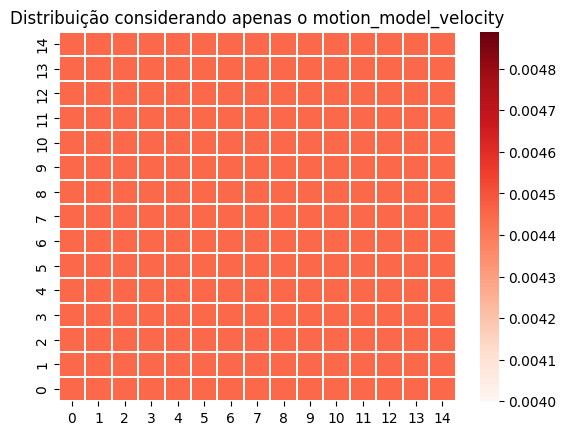

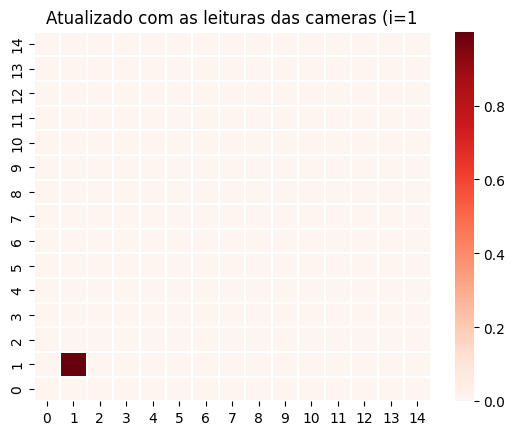

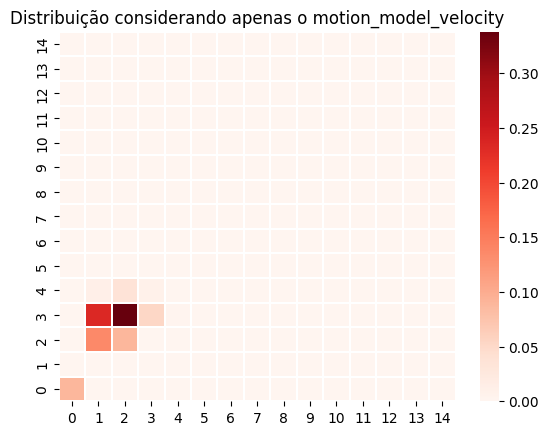

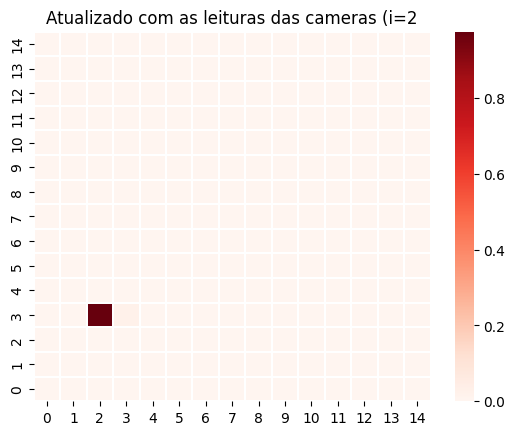

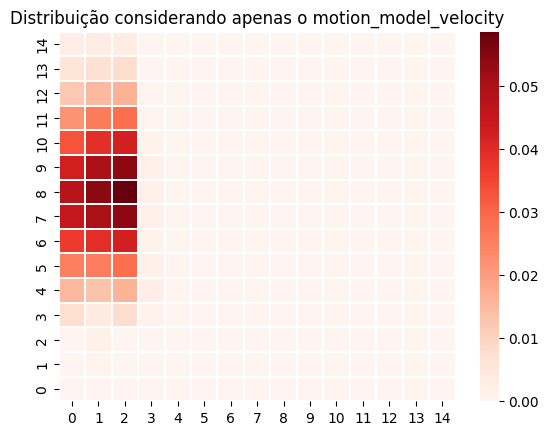

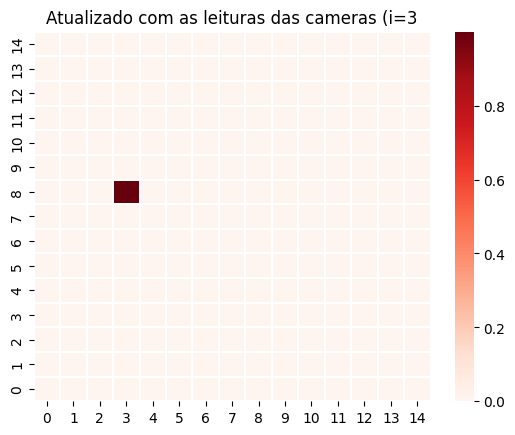

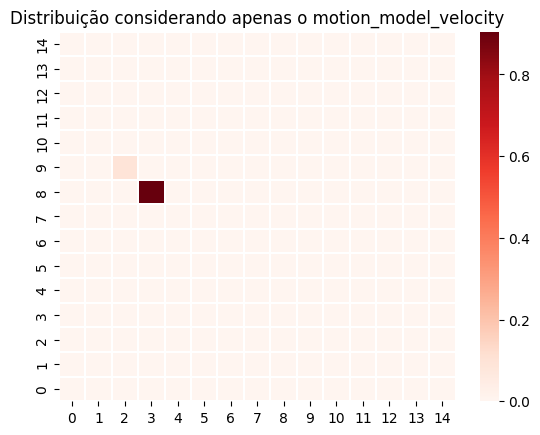

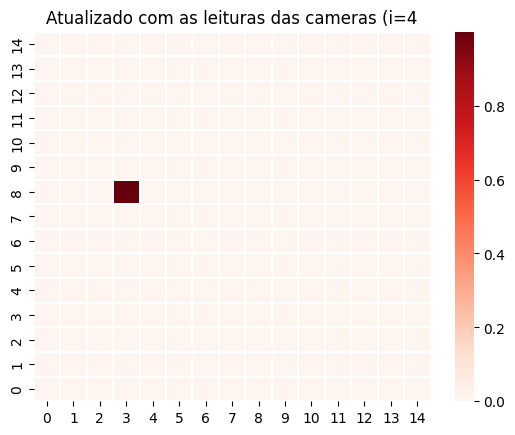

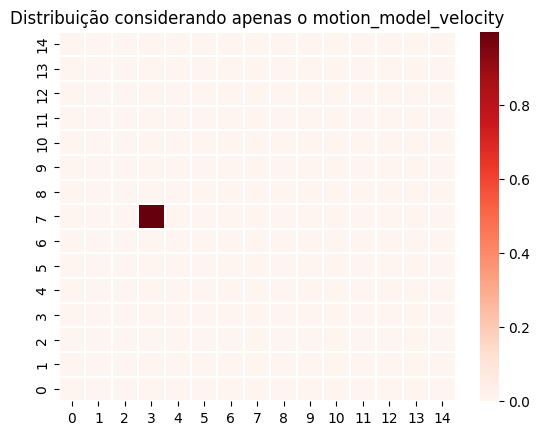

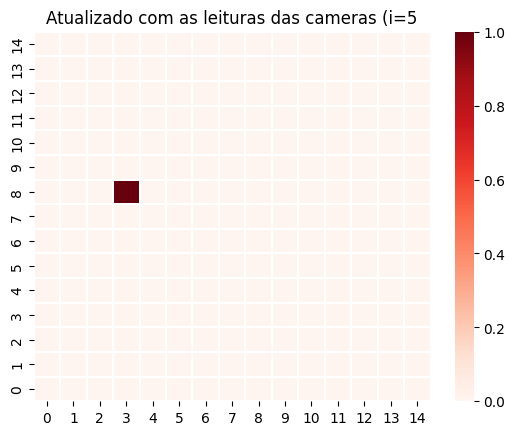

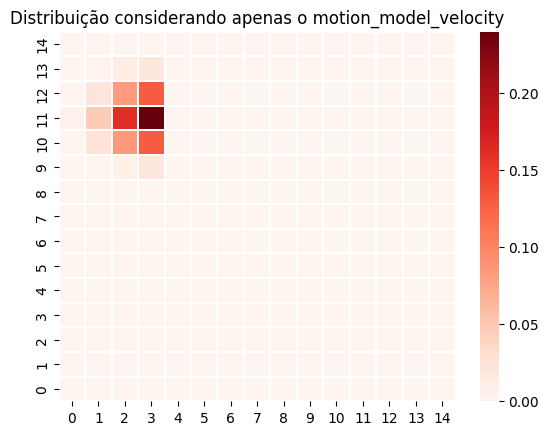

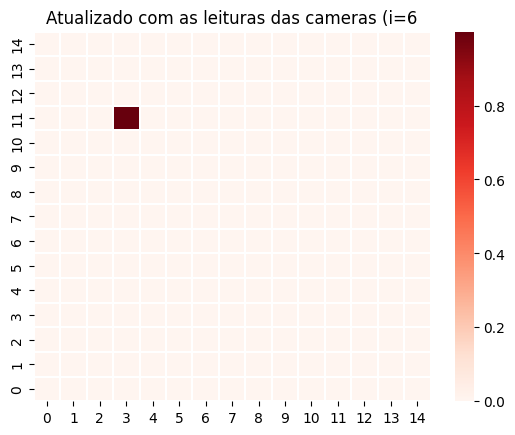

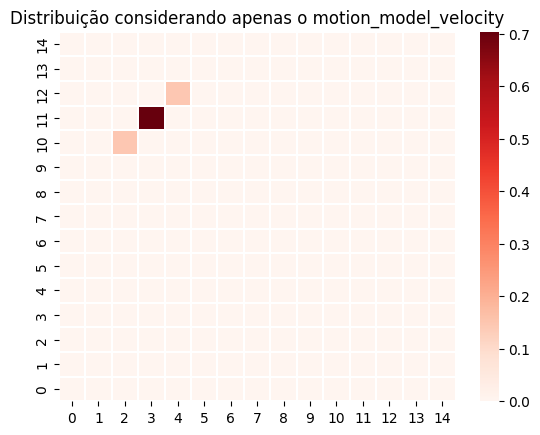

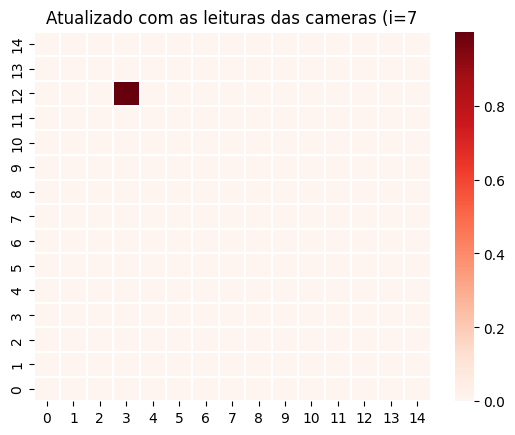

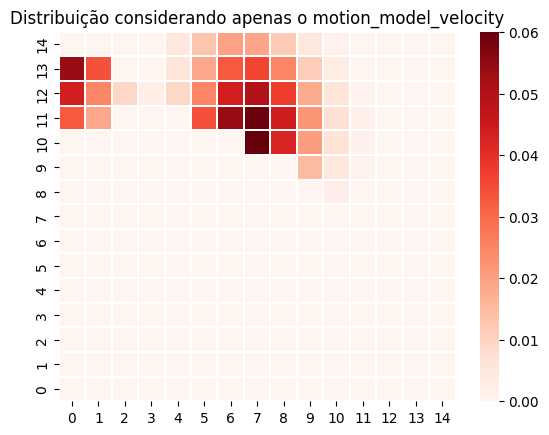

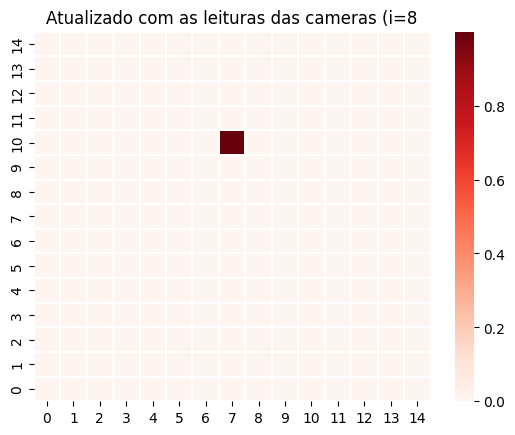

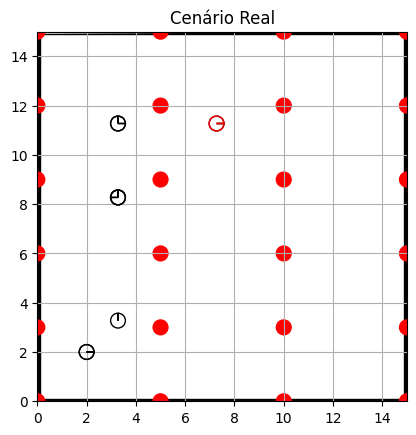

In [9]:
# %%script false --no-raise-error
obstacles = [[(0, 0), (15, 0), (15, 0.1), (0, .1)],  # paredes
             [(0, 0), (0, 15), (.1, 15), (.1, 0)],
             [(0, 14.9), (0, 14.9), (15, 14.9), (15, 15)],
             [(14.9, 15), (15, 15), (15, 0), (14.9, 0)]]

landmarks = {1: (0, 0), 2: (0, 3), 3: (0, 6),
             4: (0, 9), 5: (0, 12), 6: (0, 15),
             7: (15, 0), 8: (15, 3), 9: (15, 6),
             10: (15, 9), 11: (15, 12), 12: (15, 15),
             13: (5, 0), 14: (5, 3), 15: (5, 6),
             16: (5, 9), 17: (5, 12), 18: (5, 15),
             19: (10, 0), 20: (10, 3), 21: (10, 6),
             22: (10, 9), 23: (10, 12), 24: (10, 15)}

area_limit = [(0, 0), (0, 15), (15, 15), (15, 0)]

test_area_map = Map(landmarks=landmarks, obstacles=obstacles, area_limit=area_limit)

pt_base = PGrid((0, 0, -pi), (15, 15, pi), (1, 1, pi/3))

camera_fov = pi / 2
camera_range = 5
motion_alphas = np.array((0.1, 0.1, 0.1, 0.1, 0.1, 0.1))
percep_sigmas = (.1, .1, 0.01)
xt_real0 = np.array([[2], [2], [0]])

#### ut - entradas de controle
ut = np.array([[0, 2, 5, 0, 0, 3, 0, 4],
               [0, pi / 2, 0, pi / 2, -pi / 2, 0, -pi / 2, 0]])

if __name__ == "__main__":

    X0 = []
    xt_real = xt_real0
    min_x, max_x, min_y, max_y = test_area_map.get_map_limits()

    i = 0
    pt = pt_base
    for uti in ut.T:
        i += 1
        xti_real = xt_real[:, -1:]

        xti_real = sample_model_velocity(u_t=uti.T, x_tp=xti_real, n_samples=1, deltat=1, alphas=np.zeros(6))

        citi, fiti = test_area_map.get_visual_landmark(xti_real, camera_fov=camera_fov,
                                                       camera_range=camera_range, sigma_cam=percep_sigmas)

        pt = grid_localization(ptp=pt, ut=uti.T, fit=fiti, cit=citi, m=test_area_map,
                               motion_alphas=motion_alphas, motion_dt=1, percep_sigmas=percep_sigmas)

        pt.plot_p_grid(f"Atualizado com as leituras das cameras (i={i}")
        xt_real = np.hstack((xt_real, xti_real))


xt_real0 =  np.array([[2], [2], [0]])
xt_real = xt_real0
i = 0

xti_real = xt_real0[:, -1:]
### cenário real:
for uti in ut.T:
    i += 1
    xti_real = sample_model_velocity(u_t=uti.T, x_tp=xti_real, n_samples=1, deltat=1, alphas=np.zeros(6))
    real_robot = plot_robot_v3(xti_real.T[0], color='red', zorder=3)
    xt_real = np.hstack((xt_real, xti_real))

plot_robots_in_map(xt_real, test_area_map, real_robot, title=f'Cenário Real')

## Monte Carlo Localization

Os algoritmos de Localização por Monte Carlo realiza a representação da localização como um conjunto múltiplas hipoteses, diferentes robôs, com diferentes estados, chamadas de partículas. Este conjunto de partículas será chamado de população.

Para a estimação da evolução do estado do robô dado uma entrada de controle aplica-se o modelo de movimento (sampler) em todas as partículas. Após, com uso da leitura do sensor, que traz a informação da condição real do robô, o modelo de percepção atribui a likelihood cada uma das partículas. Esta likelihood terá uma função de ponderar um processo de reamostragem. Para implementação realizada neste trabalho os processos reamostragem utilizaram o algoritmo *Stochastic Universal Sampler*. Este processo, garante o mesmo número de amostras a cada iteração mantendo o tamanho da população constante.

## Teste Padrão

Para a verificação da funcionalidade dos algoritmos de Monte Carlo implementados foi feito um teste padrão. O teste consite no robô andando no mapa conforme apresentado na saída da célula a seguir. O movimento parte da condição condição:

$$
x_0 = \begin{bmatrix} 2 \\ 2 \\ \pi/2 \end{bmatrix}
$$

E é regido pelas seguintes entradas de controle em termos do modelo por velocidade:
$$
u_t = \begin{bmatrix}
0 & 2 & 3 & 3 & 0 & 0 & 3 & 0 & 2 & 0 \\
0 & \pi/2 & 0 & 0 & \pi/2 & -\pi/2 & -\pi/2 & 0 & 0 & 0
\end{bmatrix}
$$

Para fins de teste do algoritmo, o robô simulado é considerado determinístico e apresentou a mesma trajetória em todos os testes de algoritmos realizados. Esta abstração permite a comparação dos 3 algoritmos de Monte Carlo, sob as mesmas circunstâncias. As populção iniciais, $\chi_0$ de todos os alogirmos é a mesma e foi gerada aleatóriamente de maneira que as amostras distribuem-se uniformemente no espaço dos estados possíveis.

As iterações são graficadas de maneira que a condição atual do robô é apresentada em vermelho e todas condições anteriores em preto. As partículas de cada iteração são apresentadas em bege antes da reamostragem e em laranja após. Todos landmarks são apresentados como pontos vermelhos, no entanto, apresentam identificadores diferentes para os robôs. O robôs os identifica com sua câmera, cuja área de deteção é apresentada como uma seção angular em verde.



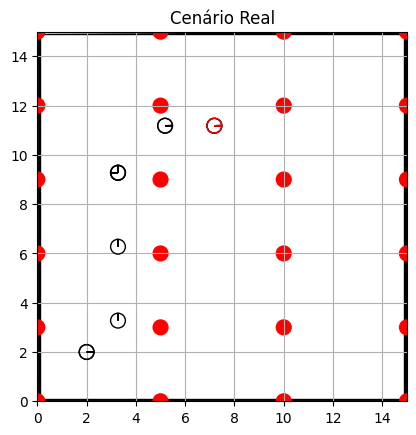

In [10]:
landmarks = {1: (0, 0), 2: (0, 3), 3: (0, 6),
             4: (0, 9), 5: (0, 12), 6: (0, 15),
             7: (15, 0), 8: (15, 3), 9: (15, 6),
             10: (15, 9), 11: (15, 12), 12: (15, 15),
             13: (5, 0), 14: (5, 3), 15: (5, 6),
             16: (5, 9), 17: (5, 12), 18: (5, 15),
             19: (10, 0), 20: (10, 3), 21: (10, 6),
             22: (10, 9), 23: (10, 12), 24: (10, 15)}
area_limit = [(0, 0), (0, 15), (15, 15), (15, 0)]
obstacles = [[(0, 0), (15, 0), (15, 0.1), (0, .1)],  # paredes
             [(0, 0), (0, 15), (.1, 15), (.1, 0)],
             [(0, 14.9), (0, 14.9), (15, 14.9), (15, 15)],
             [(14.9, 15), (15, 15), (15, 0), (14.9, 0)]]

test_area_map = Map(landmarks=landmarks, obstacles=obstacles, area_limit=area_limit)

camera_fov = pi / 2   # 90 degree centrado em theta
camera_range = 5      # meters para reconhecimento adequado
motion_alphas = np.array((0.1, 0.1, 0.1, 0.1, 0.1, 0.1))
percep_sigmas = (.5, .5, 0.01)

### ut
ut = np.array([[0,    2, 3, 3,    0,     0, 3,     0, 2, 0],
               [0, pi/2, 0, 0, pi/2, -pi/2, -pi/2, 0, 0, 0]])


### X_0
xt_real = np.array([[2], [2], [0]])

xti_real = xt_real0[:, -1:]

### cenário real:
for uti in ut.T:
    xti_real = sample_model_velocity(u_t=uti.T, x_tp=xti_real, n_samples=1, deltat=1, alphas=np.zeros(6))
    real_robot = plot_robot_v3(xti_real.T[0], color='red', zorder=3)
    xt_real = np.hstack((xt_real, xti_real))

plot_robots_in_map(xt_real, test_area_map, real_robot, title=f'Cenário Real')


## Vanila MCL

A primeira versão dos algoritmos de Localização por Monte Carlo é a básica (vanila), aplicando diretametne os conceitos apresentados na seção anterior.

Sintéticamente, a cada iteração, a implementação feita do algoritmo de Monte Carlo realiza:
1.   Aplicalção do *motion_model_velocity* em todas as partículas da população de $\chi_{t-1}$;
2.   Aplicação do *landmark_model_known_correspondence* para atribuição de likelihoods / pesos às amostras após o movimento; e
3.   Obtenção de $\chi_t$ pela reamostragem com o *stochastic_universal_sampler*.


In [11]:
def monte_carlo_localization_vel_camera(X_tp, u_t, m,
                                        cit, fit, percep_sigmas,
                                        motion_alphas, motion_deltat=1, mult_samples=1):
    """
    input:
        X_t: np.array, 3 x S -> São tratadas S amostras. Os estados são colunas [x, y, theta].T dispostas lado a lado.
        u_: np.array, 2 x 1 -> controle considerando velocidade   componentes: [v, w]
        m: Map

        # perception model
        cit: list, L -> lista dos identificadores dos landmarks no mapa.
        fit: np.array, 2 x L -> A leitura do landmark corresponde a colunas [r, phi].T.
        percep_sigmas: 3 x 1 -> desvios padrão das medições do modelo de percepção.

        # motion model
        motion_alphas:
        motion_dt

    output:
        p np.array, 1 x S -> likelihood de cada uma das amostras
    """
    assert type(m) == Map
    _, n_samples = X_tp.shape

    # aplicação do modelo de velocidade para todas as amostras.
    X_t = sample_model_velocity(u_t=u_t, x_tp=X_tp, n_samples=mult_samples, alphas=motion_alphas, deltat=motion_deltat)

    # atribuição dos pesos para cada uma das amostras. Os pesos são iniciados todos unitários e,
    # para cada landmark detectado, os pesos multiplicados pela likelihood obtida com o modelo de percepção.
    w_t = np.ones_like(X_t[0])
    for i in range(len(cit)):
        w_t = w_t * landmark_model_known_correspondence(fit=fit.T[i], cit=cit[i], m=m, xt=X_t, sigmas=percep_sigmas)

    # os indices das amostras são obtidas pelo SUS.
    survivors_index = stochastic_universal_sampler(w_array=w_t, n_samples=n_samples)

    return X_t[:, survivors_index]

### Teste - Vanila MCL

A implementação realizada é então submetida ao teste padrão proposto e seus resultados em termos de distância da condição média das partículas e a posição real do robô é armazenada para comparação posterior.

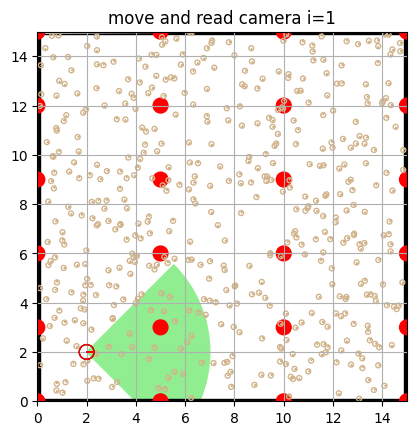

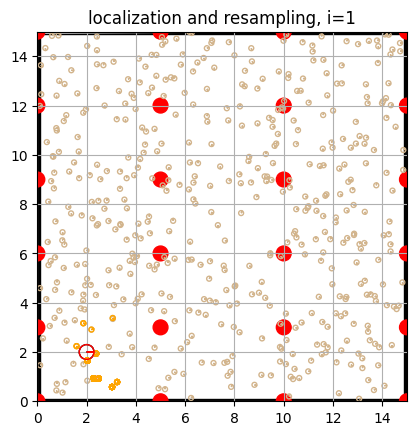

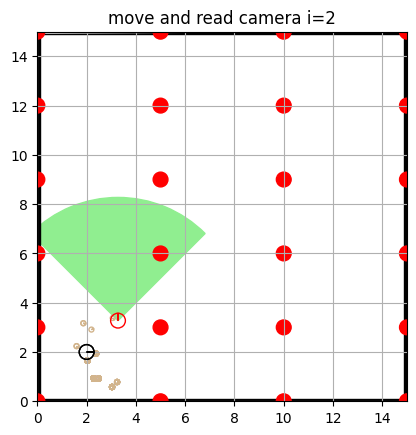

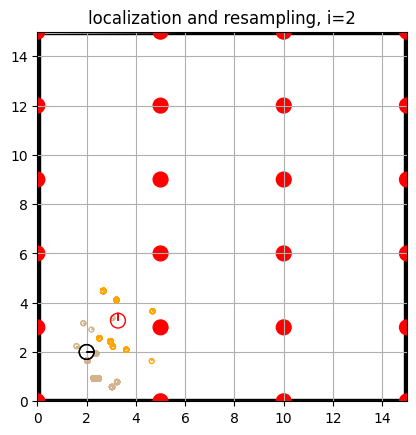

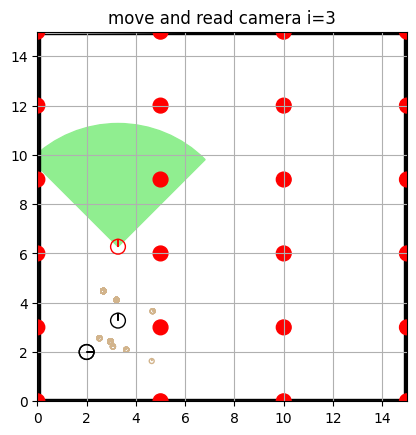

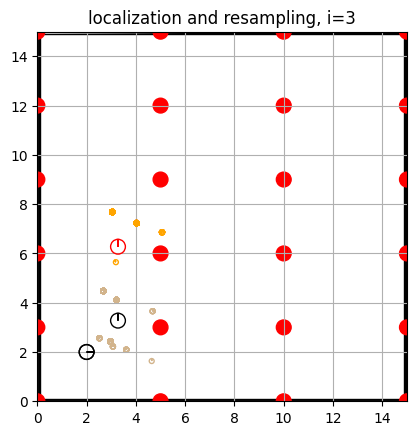

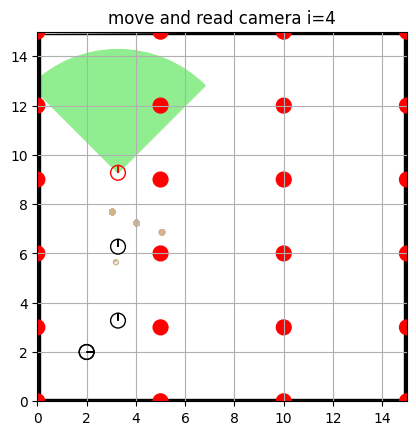

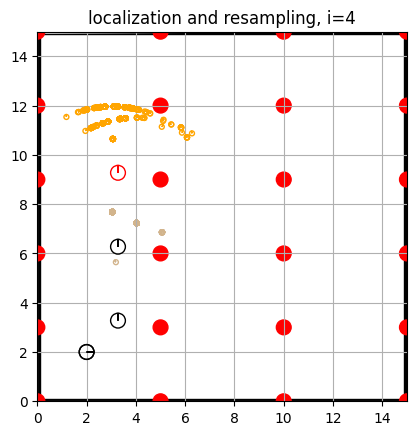

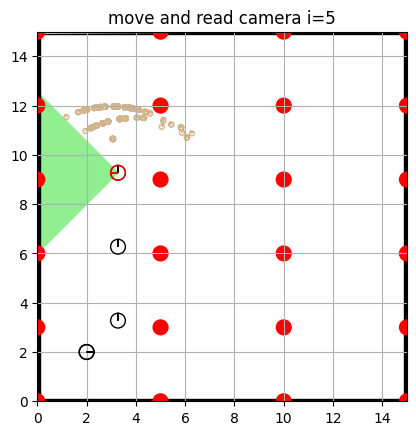

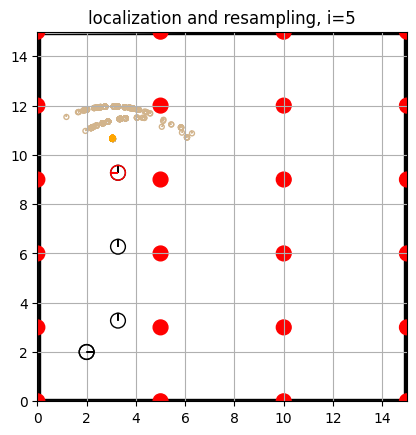

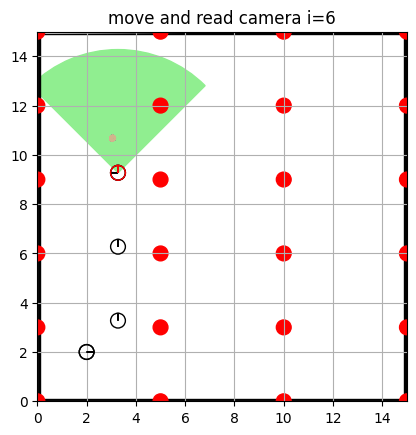

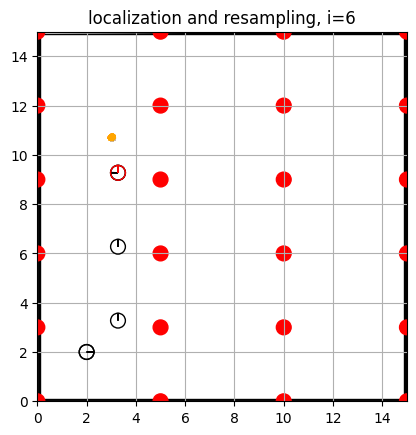

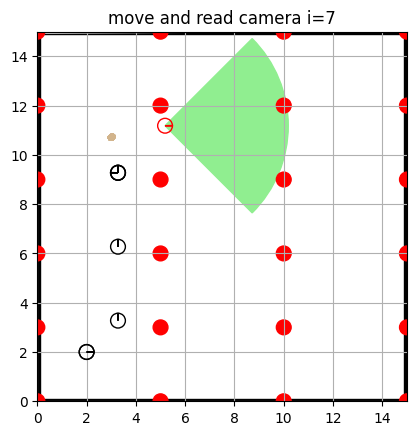

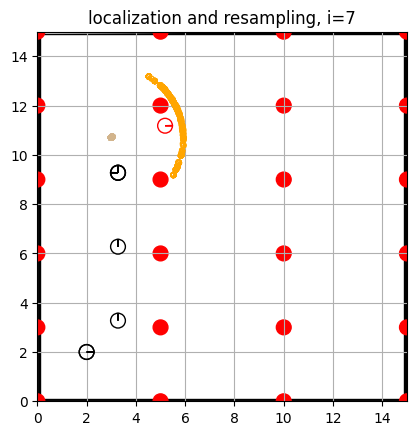

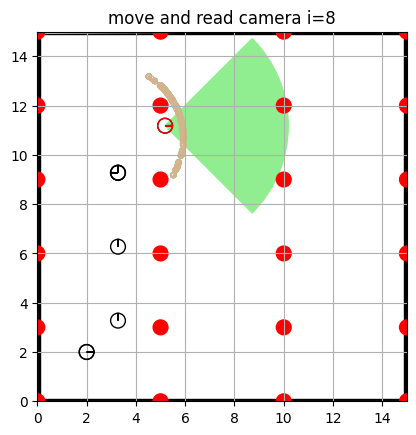

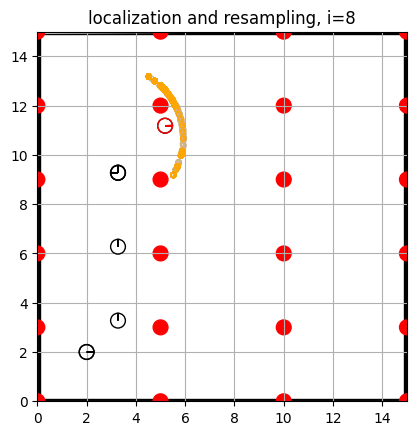

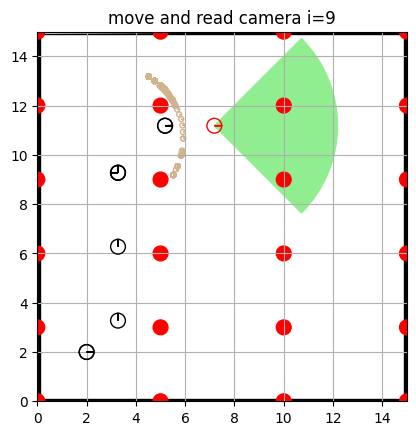

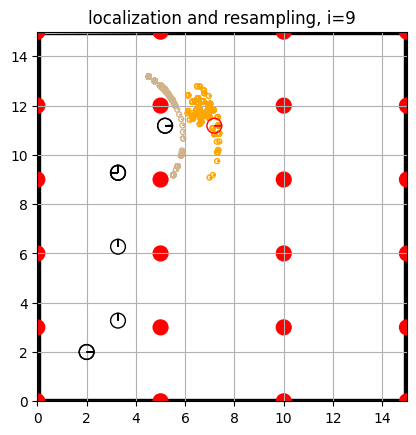

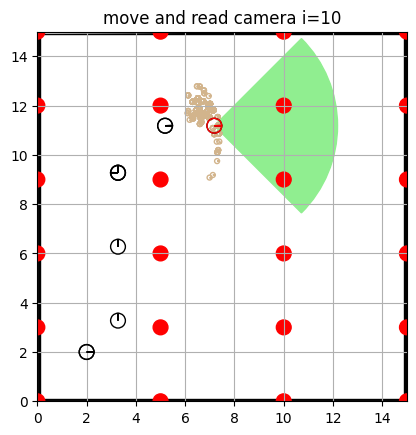

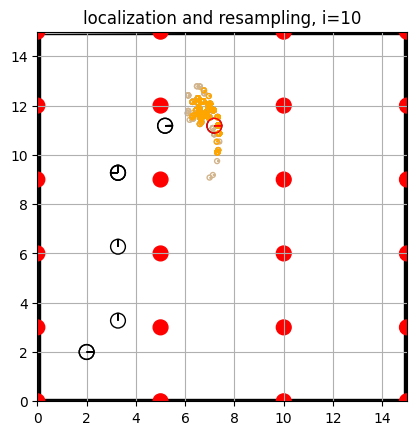

In [12]:
### comparativo distâncias médias dos três métodos de MCL
vanMCL_dist_mean_real = []



xti_real = xt_real[:, 0]
Xt = get_random_samples(500, test_area_map)

i = 0
for uti in ut.T:
    Xtp = Xt

    # read camera on with the real position
    xti_real = xt_real[:, i+1]
    citi, fiti = test_area_map.get_visual_landmark(xti_real, camera_fov=camera_fov,
                                                    camera_range=camera_range, sigma_cam=percep_sigmas)

    ### ========================= MCL ========================= ###
    Xt = monte_carlo_localization_vel_camera(X_tp=Xt, u_t=uti, m=test_area_map,
                                              cit=citi, fit=fiti, percep_sigmas=percep_sigmas,
                                              motion_alphas=motion_alphas, mult_samples=1)

    meanx = Xt[0].mean()
    meany = Xt[1].mean()
    dist = ((xti_real[0] - meanx) ** 2 + (xti_real[1] - meany) ** 2) ** .5
    vanMCL_dist_mean_real.append(dist)
    ### ========================= MCL ========================= ###

    i += 1
    plot_MCL_scene(Xtp, Xt, xt_real, i, camera_range, camera_fov, test_area_map)

### Análise do Resultado - MCL

No teste proposto o algoritmo apresentou partículas cujas médias apresentaram distâncias sempre inferiores a 2.5m. Constata-se assim o funcionamento adequado do algoritmo com algum nível de precisão para o cenário e parâmetros propostos.
A distância média das partículas sofre um aumento em iterações intermediárias, entede-se que por efeito da saída da inércia para condição posicionamento continuamente variante. Porém em seguida, o algoritmo parece concentrar as partículas de forma a aderir bem a posição real. No entanto, a concentração das partículas pode ser interpretada como uma redundância que implica, de certa forma, em uma perda de eficiencia.


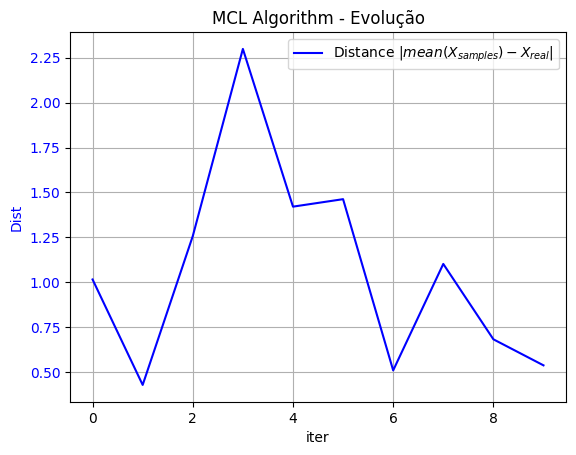

In [20]:
### plot evolução
fig, ax = plt.subplots()

# Plot the first data on the primary y-axis
ax.plot(vanMCL_dist_mean_real, label=r'Distance |$mean(X_{samples}) - X_{real}$|', color='blue')
ax.set_xlabel('iter')
ax.set_ylabel('Dist', color='blue')
ax.tick_params(axis='y', labelcolor='blue')


# Add legends
lines, labels = ax.get_legend_handles_labels()
labels = labels
ax.legend(lines, labels, loc='upper right')

# Show the plot
plt.grid()
plt.title('MCL Algorithm - Evolução')
plt.show()

## Augmented Monte Carlo Localization

A primeira versão modificada do algoritmo de localização de Monte Carlo é sua versão chamada de aumentada. Esta versão apresenta dois parâmetros $\alpha_{slow}$ e $\alpha_{fast}$ que regem os comportamentos dos pesos $w_{slow}$ e $w_{fast}$. De acordo com o comportamento destes pesos, o algoritmo seleciona amostras aleatóriamente. As equações que regem o comportamento destes pesos é:
$$
    w_{slow} = w_{slow} + \alpha_{slow} * (w_{avg} - w_{slow})
$$
$$
    w_{fast} = w_{fast} + \alpha_{fast} * (w_{avg} - w_{fast})
$$
Para o funcionamento efetivo do algoritmo $w_{fast} >> w_{slow}$. Desta forma se há uma mudança mais relevante da média das likelihoods da população $w_{avg}$ o peso rápido, $w_{fast}$ irá sofrer uma maior perturbação a princípio en quanto o peso lento $w_{slow}$ apresentará maior inércia para se assentar. Esta diferença de dinâmicas então é utilizada para que uma parte da população sofra um reset, ou seja, passe a ser escolhida aleatóriamente de acordo com a equação:
$$ max(0, 1 - w_{fast} / w_{slow}) $$
Assim, uma maior divergência entre as médias das likelihoods de curto e de longo prazo implica um maior número de amostras aleatórias sendo inseridas na população.

Este mecanismo permite que o algoritmo de localização seja capaz de detectar falhas e se recuperar de condições nas quais haja um descasamento de leitura e estado como por exemplo em uma situção de "sequestro".

In [13]:
def augmented_monte_carlo_localization_vel_camera(X_tp, u_t, m,
                                                  cit, fit, percep_sigmas,
                                                  motion_alphas, motion_deltat=1, mult_samples=1,
                                                  wslow=.1, wfast=.1, alphaslow=0.01, alphafast=10.):
    """
    input:
        X_t: np.array, 3 x S -> São tratadas S amostras. Os estados são colunas [x, y, theta].T dispostas lado a lado.
        u_: np.array, 2 x 1 -> controle considerando velocidade   componentes: [v, w]
        m: Map

        # perception model
        cit: list, L -> lista dos identificadores dos landmarks no mapa.
        fit: np.array, 2 x L -> A leitura do landmark corresponde a colunas [r, phi].T.
        percep_sigmas: 3 x 1 -> desvios padrão das medições do modelo de percepção.

        # motion model
        motion_alphas:
        motion_dt

    output:
        p np.array, 1 x S -> likelihood de cada uma das amostras
    """
    assert type(m) == Map
    min_x, max_x, min_y, max_y = m.get_map_limits()

    _, n_samples = X_tp.shape

    # amostra a partir das amostras de t-1 com o modelo de movimento.
    X_t = sample_model_velocity(u_t=u_t, x_tp=X_tp, n_samples=mult_samples,
                                alphas=motion_alphas, deltat=motion_deltat)

    # likelihood das amostras advindas do modelo de movimento.
    w_t = np.ones_like(X_t[0])
    for i in range(len(cit)):
        w_t = w_t * landmark_model_known_correspondence(fit=fit.T[i], cit=cit[i], m=m,
                                                        xt=X_t, sigmas=percep_sigmas)

    X_t = np.vstack((X_t, w_t))

    # calculo da dinâmica dos pesos e número de amostras esperado,
    # regulado pelo número original de amostras
    wavg = w_t.mean()
    wslow = wslow + alphaslow * (wavg - wslow)
    wfast = wfast + alphafast * (wavg - wfast)

    n_rand_samp = int(max(0, 1 - wfast / wslow) * n_samples)
    n_rand_samp = min(n_rand_samp, n_samples)

    # caso seja necssário, são amostradas aleatóriamente o número de amostras
    # preconizado pelo algoritmo
    if n_rand_samp > 0:
        rand_x = np.random.uniform(min_x, max_x, n_rand_samp)
        rand_y = np.random.uniform(min_y, max_x, n_rand_samp)
        rand_theta = np.random.uniform(-pi, pi, n_rand_samp)
        X_rand = np.vstack((rand_x, rand_y, rand_theta))

        # pesos das amostras aleatórias.
        w_rand = np.ones_like(X_rand[0])
        for i in range(len(cit)):
            w_rand = w_rand * landmark_model_known_correspondence(fit=fit.T[i], cit=cit[i], m=m,
                                                                  xt=X_rand, sigmas=percep_sigmas)

        X_rand = np.vstack((X_rand, w_rand))

        # unem-se as amostras aleatórias e do modelo de movimento
        X_t = np.hstack((X_t, X_rand))
        w_t = X_t[3, :]

    # selecionam-se os sobreviventes entra as amostras do modelo e as aleatórias
    survivors_index = stochastic_universal_sampler(w_array=w_t, n_samples=n_samples)

    X_t = X_t[:3, survivors_index]

    return X_t, wslow, wfast

### Teste do Augmented MCL

A implementação realizada é então submetida ao teste padrão proposto e seus resultados em termos de distância da condição média das partículas e a posição real do robô é armazenada para comparação posterior.


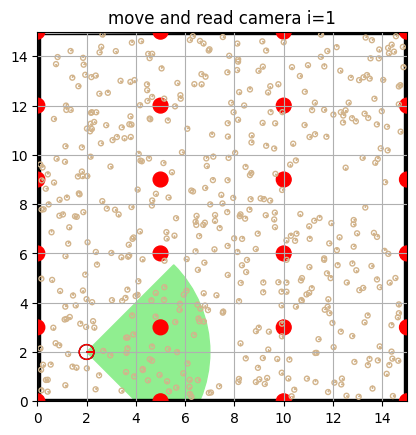

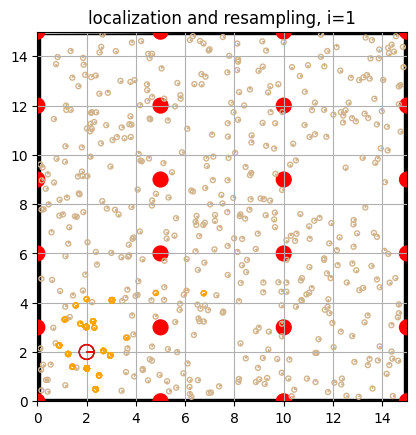

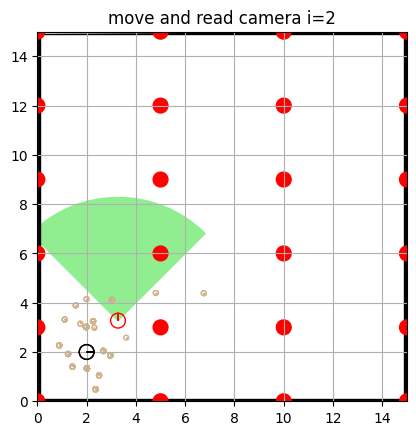

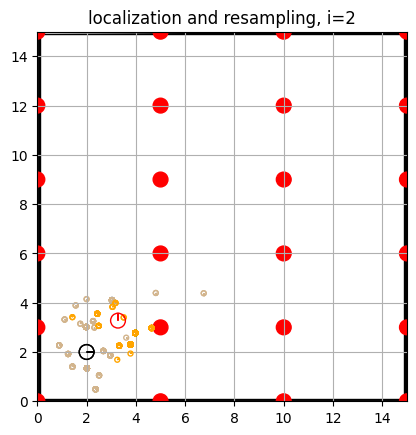

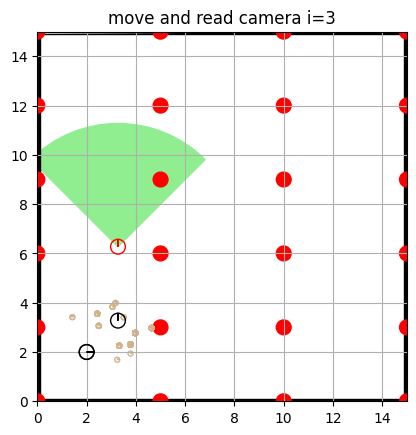

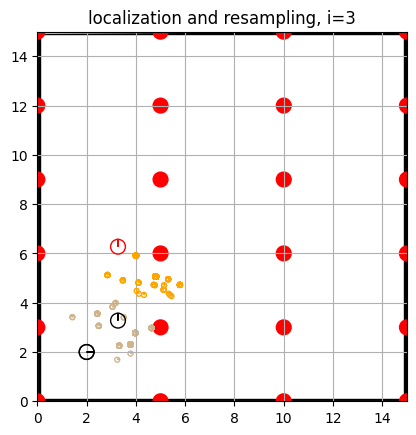

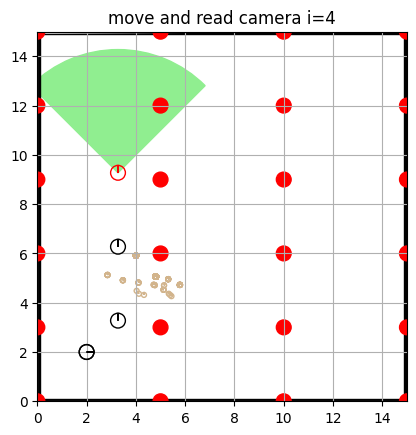

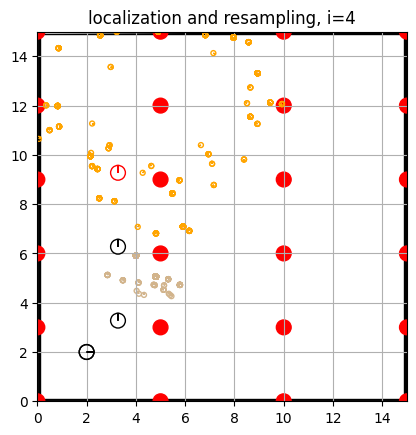

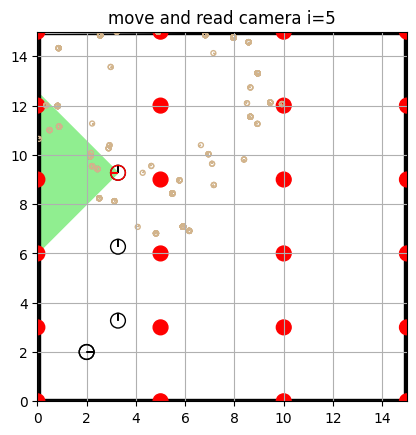

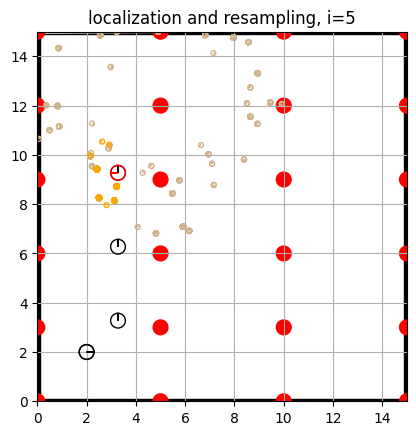

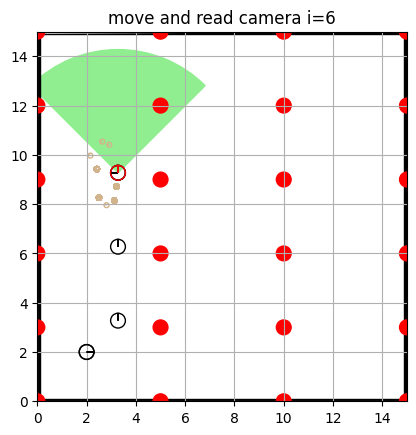

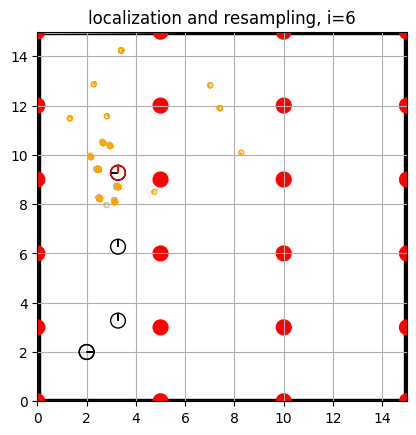

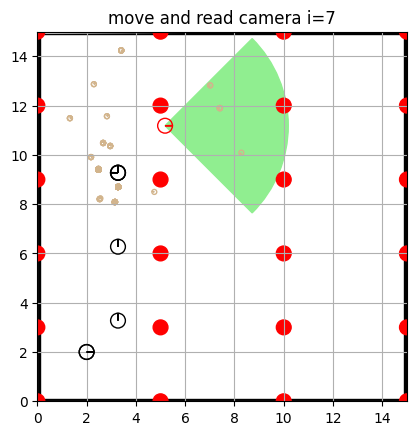

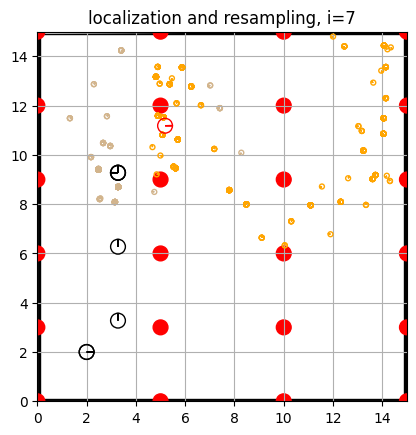

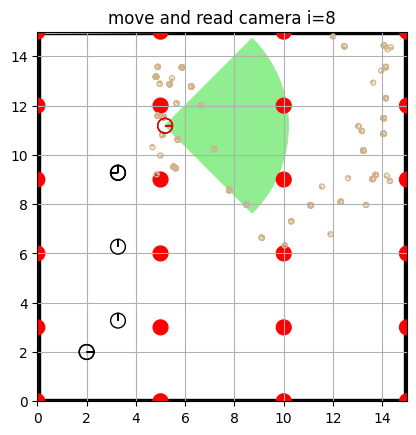

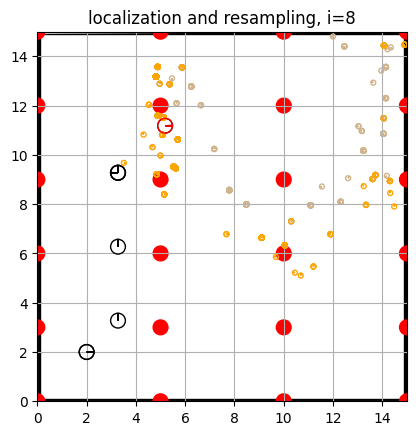

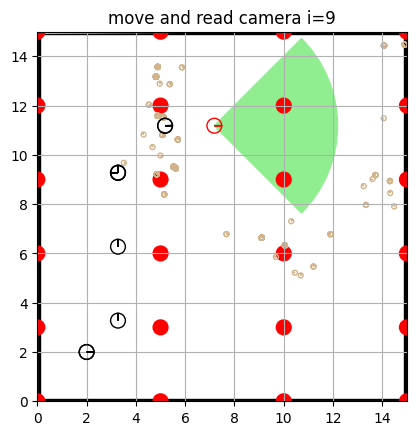

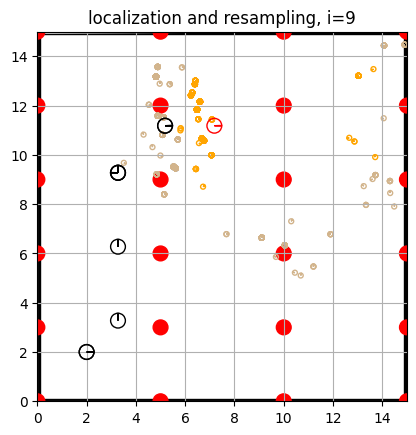

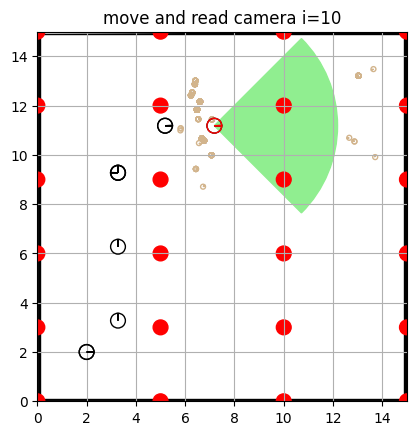

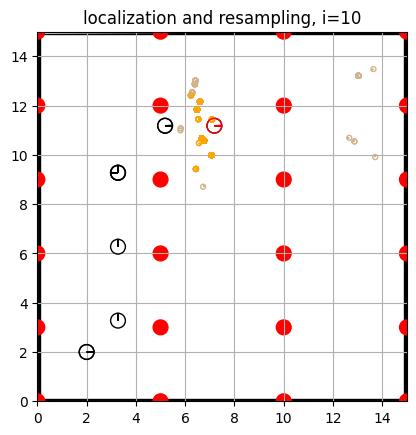

In [14]:
### comparativo distâncias médias dos três métodos de MCL
augMCL_dist_mean_real = []

xti_real = xt_real[:, 0]
Xt = get_random_samples(500, test_area_map)

i = 0
wslow = .1
wfast = 10.
for uti in ut.T:
    Xtp = Xt

    # read camera given the real position
    xti_real = xt_real[:, i+1]
    citi, fiti = test_area_map.get_visual_landmark(xti_real, camera_fov=camera_fov,
                                                    camera_range=camera_range, sigma_cam=percep_sigmas)


    ### ======================= Aug-MCL ======================= ###
    Xt, wslow, wfast = augmented_monte_carlo_localization_vel_camera(X_tp=Xt, u_t=uti, m=test_area_map,
                                                                      cit=citi, fit=fiti, percep_sigmas=percep_sigmas,
                                                                      motion_alphas=motion_alphas, mult_samples=1,
                                                                      wslow=wslow,
                                                                      wfast=wfast,
                                                                      alphaslow=0.1,
                                                                      alphafast=.8)
    meanx = Xt[0].mean()
    meany = Xt[1].mean()
    dist = ((xti_real[0] - meanx)**2 + (xti_real[1] - meany)**2)**.5
    augMCL_dist_mean_real.append(dist)
    ### ======================= Aug-MCL ======================= ###


    i += 1
    plot_MCL_scene(Xtp, Xt, xt_real, i, camera_range, camera_fov, test_area_map)


### Análise do Resultado - Augmented MCL
Na figura gerada pela próxima célula é apresentado a evolução da distância da distância mêdia das amostras para o robô real.

Observa-se que as partículas geradas pelo algoritmo apresentam sempre uma distância inferior a 4 metros para o teste proposto com os parâmetros empregados. Na iteração em que há um movimento de rotação e translação simultâneos houve um aumento do número de amostras aleatórias, no entanto, isto pode ser somente o efeito de uma má escolha de parâmetros, sendo necessário melhor ajuste dos mesmos.

Apesar das amostras aleatórias permitirem uma maior resiliência da localização estas incorrem no afastamento da partícula média da posição real estimada, na ausência de um ajuste fino dos parâmetros do algoritmo.

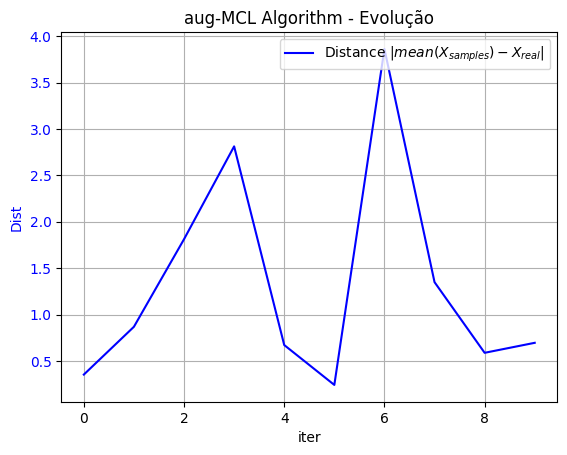

In [19]:
### plot evolução
fig, ax = plt.subplots()

# Plot the first data on the primary y-axis
ax.plot(augMCL_dist_mean_real, label=r'Distance |$mean(X_{samples}) - X_{real}$|', color='blue')
ax.set_xlabel('iter')
ax.set_ylabel('Dist', color='blue')
ax.tick_params(axis='y', labelcolor='blue')


# Add legends
lines, labels = ax.get_legend_handles_labels()
labels = labels
ax.legend(lines, labels, loc='upper right')

# Show the plot
plt.grid()
plt.title('aug-MCL Algorithm - Evolução')
plt.show()

## Kullback-Leibler Divergence Sampler Monte Carlo Localization Algorithm

Uma segunda modificação do algoritmo de localização de Monte Carlo busca alterar adaptativamente a quantidade de amostras visando otimizar o custo computacional destinado para localização.

Para isso, o algoritmo utiliza um histograma que discretiza o espaço de estados e então as amostras são geradas de acordo com a ocupação deste histograma. Caso a amostra gerada seja pertencente a uma célula já ocupada anteriormente há incremento da variável $k$. A cada amostra gerada, o número de amostras é comparado com uma função analítica de $k$ derivada da divergência de Kullback-Leibler, que indica a variação da distribuição das amostras conforme estas vão sendo geradas dada por:

$$
M_\chi = \frac{(k -1)}{(2\varepsilon)} \Bigg[1 - \frac{2}{9(k-1)} + \sqrt{\frac{2}{9(k-1)}}z_{1-\delta} \Bigg]
$$


Desta maneira, o algoritmo evita a adição de novas amostras que não tenham influencia relevante no deslocamento a distribuição de amostras. Ou seja, uma vez que o número de amostras é suficiente para que haja uma convergência da distribuição, não são geradas novas amostras.

In [15]:
def KLD_Sampling_MCL_vel_camera(X_tp, u_t, m,
                                cit, fit, percep_sigmas,
                                motion_alphas, motion_deltat=1,
                                M_X_min=100, eps=0.05, delta=0.1, M_max=1000,
                                min_scales=(0, 0, -pi), max_scales=(15, 15, pi), res=(0.5, 0.5, pi/18)):
    """
    input:
        X_t: np.array, 3 x S -> São tratadas S amostras. Os estados são colunas [x, y, theta].T dispostas lado a lado.
        u_: np.array, 2 x 1 -> controle considerando velocidade   componentes: [v, w]
        m: Map

        # perception model
        cit: list, L -> lista dos identificadores dos landmarks no mapa.
        fit: np.array, 2 x L -> A leitura do landmark corresponde a colunas [r, phi].T.
        percep_sigmas: 3 x 1 -> desvios padrão das medições do modelo de percepção.

        # motion model
        motion_alphas:
        motion_dt

    output:
        p np.array, 1 x S -> likelihood de cada uma das amostras
    """
    assert type(m) == Map
    _, n_samples = X_tp.shape

    w_tp = X_tp[3]
    X_t = np.array([[], [], [], []])
    H = HGrid(min_scales, max_scales, res)
    M, M_x, k = 0, 0, 0
    min_x, max_x, min_y, max_y = m.get_map_limits()

    while M < M_x or M < M_X_min:
        i_p = stochastic_universal_sampler(w_tp, 1)
        x_M = sample_model_velocity(u_t=u_t, x_tp=X_tp[:, i_p], n_samples=1,
                                    alphas=motion_alphas, deltat=motion_deltat)
        x_M[0] = np.clip(x_M[0], a_min=min_x, a_max=max_x)
        x_M[1] = np.clip(x_M[1], a_min=min_y, a_max=max_y)
        x_M[2] = normalize_angle(x_M[2])

        w_t = np.ones(1)
        for i in range(len(cit)):
            w_t = w_t * landmark_model_known_correspondence(fit=fit.T[i], cit=cit[i], m=m, xt=x_M, sigmas=percep_sigmas)

        x_M = np.vstack((x_M, w_t))
        X_t = np.hstack((X_t, x_M))
        M += 1

        if H.value[H.state_to_idx(x_M)] == 0:
            k += 1
            H.value[H.state_to_idx(x_M)] += 1
            if k > 1:
                zdelta = norm.ppf(1 - delta)
                M_x = (k-1)/2/eps*(1 - 2 / 9 / (k - 1) + sqrt(2 / 9 / (k - 1)) * zdelta)**3

    print(f"KLDMCL iter end M: {M}, M_x: {M_x}, M_X_min: {M_X_min}")
    return X_t


### Teste do KLD-Sampler MCL

A implementação realizada é então submetida ao teste padrão proposto e seus resultados em termos de distância da condição média das partículas e a posição real do robô é armazenada para comparação posterior.

É necessário salientar, que para os plots deste algoritmo há restrição para que no máximo 1000 partículas sejam representadas para viabilização computacional da execução da graficação.



KLDMCL iter end M: 224, M_x: 223.0997800065388, M_X_min: 50
i: 0, Xt.shape: (4, 224)


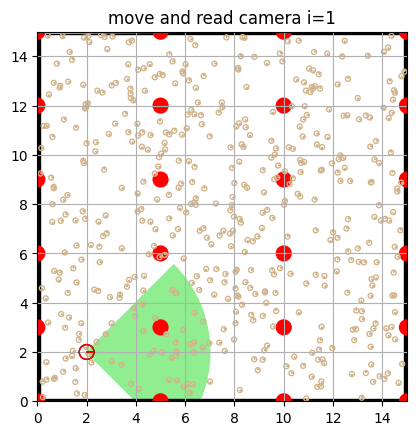

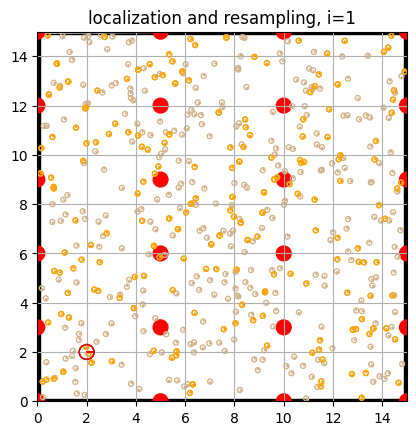

KLDMCL iter end M: 1484, M_x: 1483.256231203626, M_X_min: 50
i: 1, Xt.shape: (4, 1484)


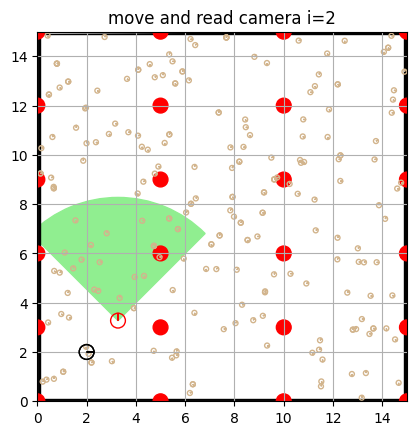

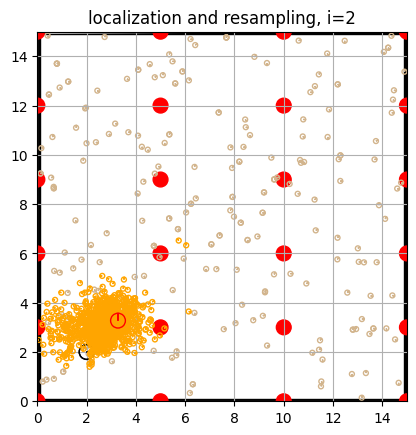

KLDMCL iter end M: 487, M_x: 486.45295385220095, M_X_min: 50
i: 2, Xt.shape: (4, 487)


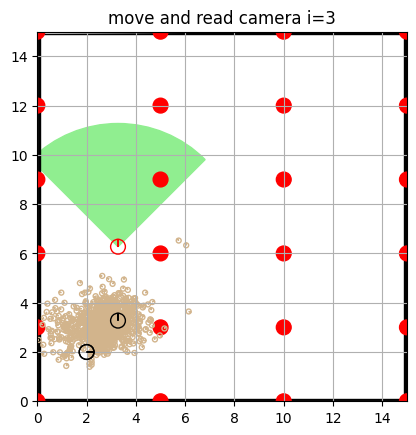

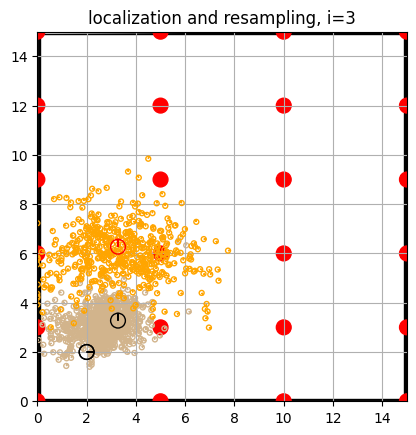

KLDMCL iter end M: 689, M_x: 688.8688235876089, M_X_min: 50
i: 3, Xt.shape: (4, 689)


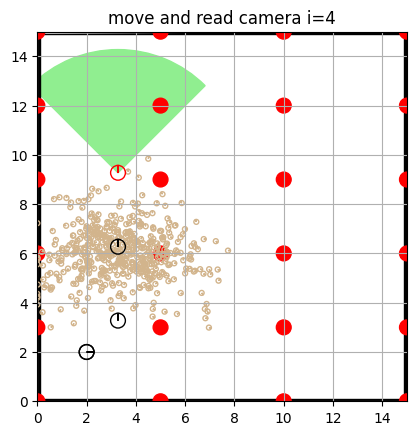

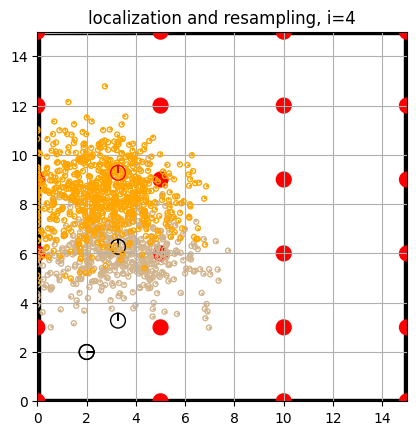

KLDMCL iter end M: 327, M_x: 326.7852661777619, M_X_min: 50
i: 4, Xt.shape: (4, 327)


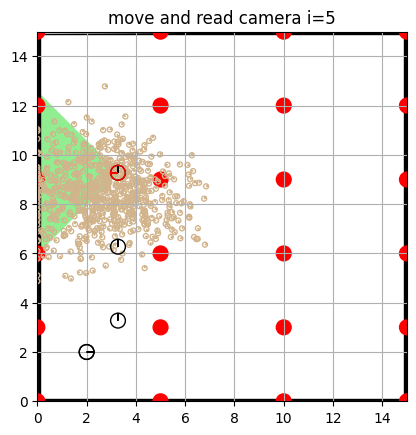

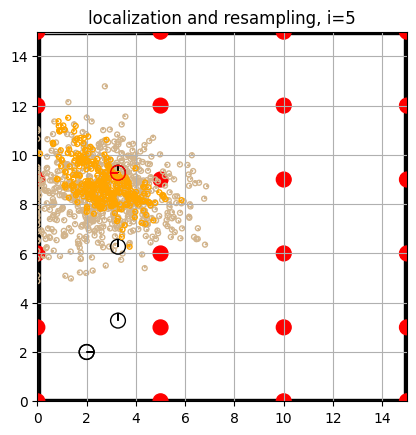

KLDMCL iter end M: 84, M_x: 83.81256069190728, M_X_min: 50
i: 5, Xt.shape: (4, 84)


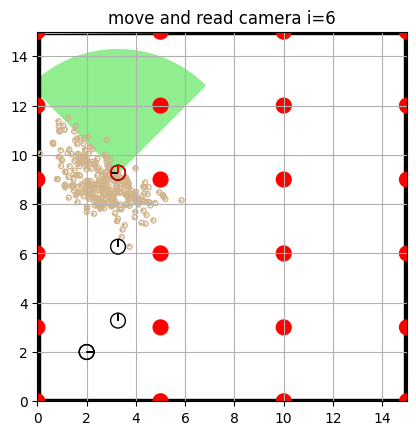

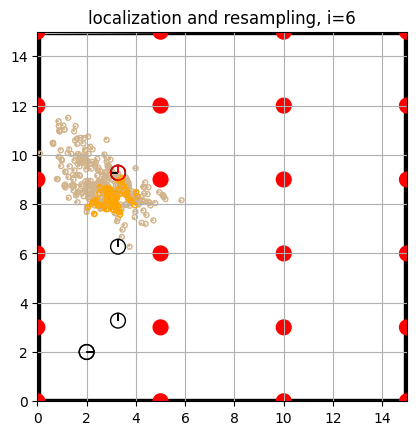

KLDMCL iter end M: 148, M_x: 147.31418376948508, M_X_min: 50
i: 6, Xt.shape: (4, 148)


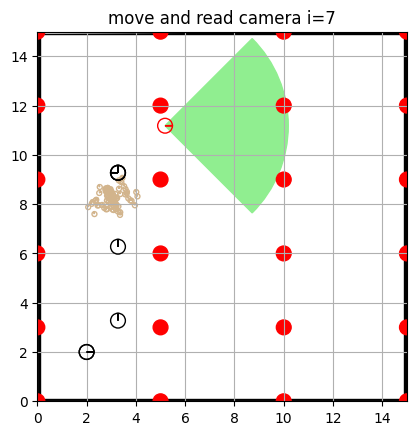

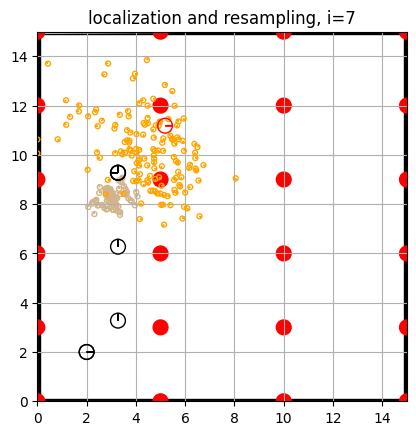

KLDMCL iter end M: 50, M_x: 32.230431662474516, M_X_min: 50
i: 7, Xt.shape: (4, 50)


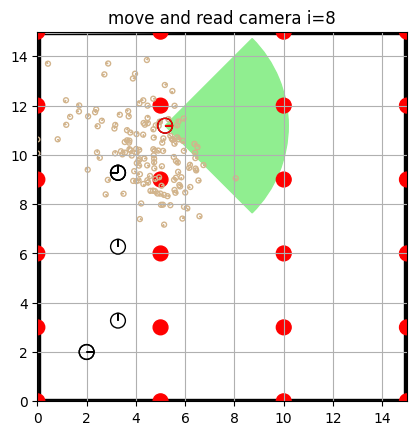

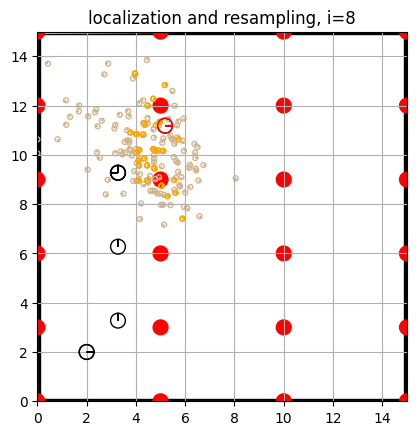

KLDMCL iter end M: 50, M_x: 43.28865634377276, M_X_min: 50
i: 8, Xt.shape: (4, 50)


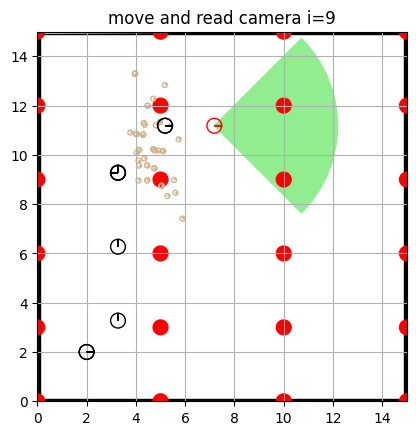

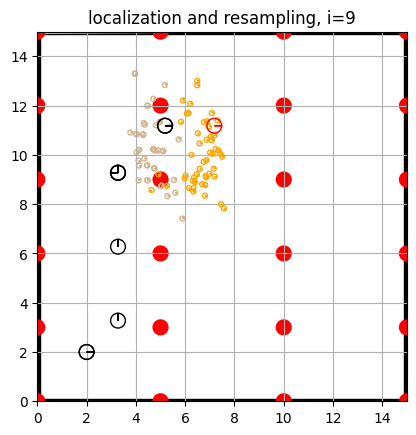

KLDMCL iter end M: 50, M_x: 6.017472050430288, M_X_min: 50
i: 9, Xt.shape: (4, 50)


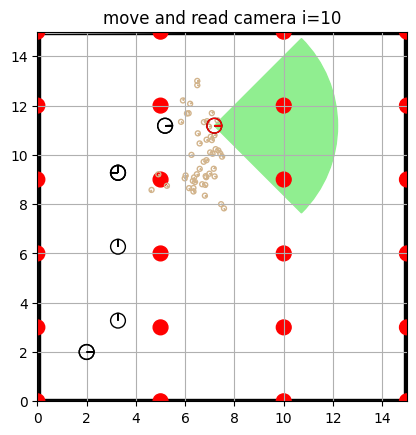

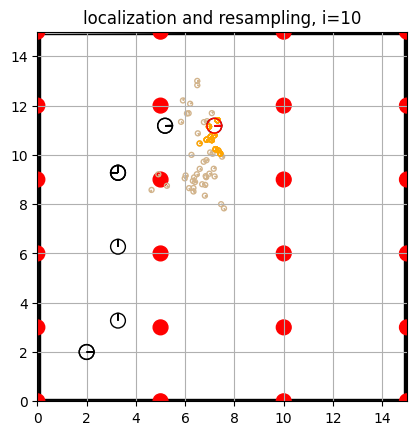

In [16]:
### comparativo distâncias médias dos três métodos de MCL
KLDMCL_dist_mean_real = []
KLD_n_samples = []


xti_real = xt_real[:, 0]
Xt = get_random_samples(500, test_area_map)

i = 0
for uti in ut.T:
    Xtp = Xt

    # read camera on with the real position
    xti_real = xt_real[:, i+1]
    citi, fiti = test_area_map.get_visual_landmark(xti_real, camera_fov=camera_fov,
                                                    camera_range=camera_range, sigma_cam=percep_sigmas)

    ### ======================= KLD-MCL ======================= ###

    Xt = KLD_Sampling_MCL_vel_camera(X_tp=Xt, u_t=uti, m=test_area_map,
                                      cit=citi, fit=fiti, percep_sigmas=percep_sigmas,
                                      motion_alphas=motion_alphas, motion_deltat=1,
                                      M_X_min=50, eps=0.2, delta=0.3,
                                      min_scales=(0, 0, -pi), max_scales=(15, 15, pi), res=(0.2, 0.2, pi/18))

    print(f"i: {i}, Xt.shape: {Xt.shape}")
    KLD_n_samples.append(Xt.shape[1])

    meanx = Xt[0].mean()
    meany = Xt[1].mean()
    dist = ((xti_real[0] - meanx)**2 + (xti_real[1] - meany)**2)**.5
    KLDMCL_dist_mean_real.append(dist)

    ### ======================= KLD-MCL ======================= ###


    i += 1
    plot_MCL_scene(Xtp, Xt, xt_real, i, camera_range, camera_fov, test_area_map)



### Análise do Resultado - KLD MCL


Devido a dinâmica das amostras deste algoritmo, é interessante observar a evolução do número de amostras contra o erro em posição médio das amostras. Para isto, estas duas variáveis são apresentadas com o decorrer das iterações do algoritmo.

Observa-se que após a 4ª iteração o algoritmo utiliza um número de amostras inferior a 200 para representar a localização do robô sem que haja incremento da distância da posição real. Isto demonstra a eficiência do algoritmo no cenário proposto. Observa-se ainda, um pico do número de amostras podendo ser interpretada como uma resposta do algoritmo à condição inicial, na qual há uma entropia muito alta na informação. Assim após a concentração da população.

Entende-se que o algoritmo tem uma tendência de tentar concentrar as partículas e com isso posucas amostras são necessárias, porém efetivas na representação do problema real.

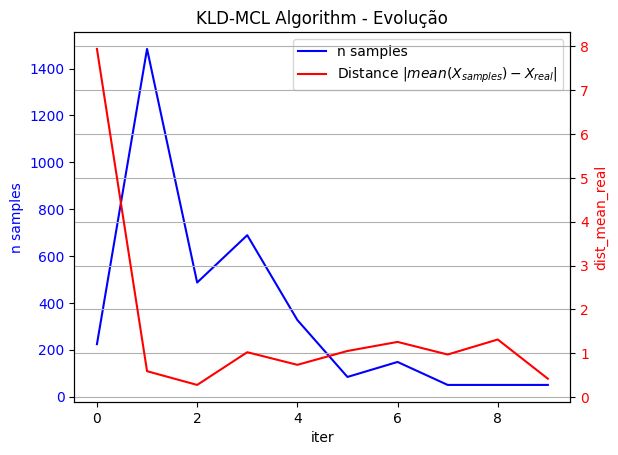

In [17]:
### plot evolução
fig, ax1 = plt.subplots()

# Plot the first data on the primary y-axis
ax1.plot(KLD_n_samples, label='n samples', color='blue')
ax1.set_xlabel('iter')
ax1.set_ylabel('n samples', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis and plot the second data on it
ax2 = ax1.twinx()
ax2.plot(KLDMCL_dist_mean_real, label=r'Distance |$mean(X_{samples}) - X_{real}$|', color='red')
ax2.set_ylabel('dist_mean_real', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper right')

# Show the plot
plt.grid()
plt.title('KLD-MCL Algorithm - Evolução')
plt.show()

## Comparativo de algoritmos Monte Carlo Localization

A célula a seguir apresenta a evolução da distância média das partículas geradas pelos três algoritmos implementados em função das iterações.

Com este gráfico é possível observar o que o KLDMCL apresenta o melhor desempenho para o teste proposto em termos de distância média de partícula. Soma-se a isso, o fato de que o número de amostras deste algoritmo após a 4ª iteração foi inferior ao utilizado pelos demais, que utilizam sempre 500, sendo assim, mais eficiente computacionalmente também.

Observa-se que o aug-MCL e KLD-MCL apresentam comportamentos complementares. Enquanto, o aug-MCL apresenta um viés mais direcionado a exploração do mapa dispersando as amostras, o KLD-MCL provoca a concentração destas visando a eficiência. Portanto, cogita-se que a combinação das modificações dos mesmos pode ser combinada visando uma solução de compromisso que represente um algoritmo ao mesmo tempo eficiente e resiliente.

Conclui-se que todos os algoritmos de filtros de partículas e Grid Localization propostos no Trabalho 4 foram implementados adequadamente e testado.


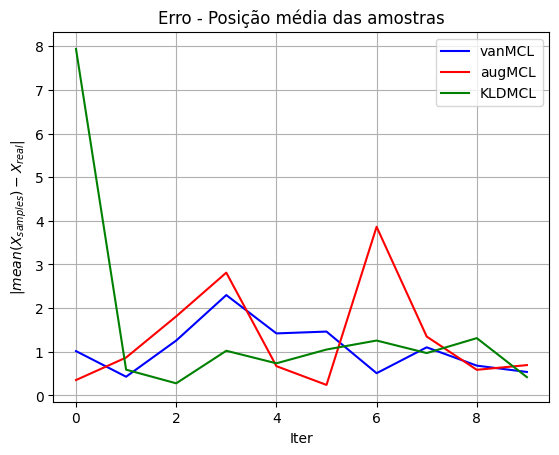

In [18]:
fig, ax = plt.subplots()

# Plot the three lists with labels
ax.plot(vanMCL_dist_mean_real, label='vanMCL', color='blue')
ax.plot(augMCL_dist_mean_real, label='augMCL', color='red')
ax.plot(KLDMCL_dist_mean_real, label='KLDMCL', color='green')

# Set axis labels and title
ax.set_xlabel('Iter')
ax.set_ylabel(r'|$mean(X_{samples}) - X_{real}$|')
ax.set_title('Erro - Posição média das amostras')

# Add a legend
ax.legend()
plt.grid()

# Show the plot
plt.show()